# Bi-variate analysis using Liana+

## Generate anndata object from Molkart output

In [1]:
from numpy.random import default_rng
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np

import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix


sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

import warnings
warnings.filterwarnings('ignore')

li.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/florian_wuennemann/miniconda3/envs/liana_plus/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/florian_wuennemann/miniconda3/envs/liana_plus/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behav

scanpy==1.9.4 anndata==0.10.4 umap==0.5.3 numpy==1.26.3 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
squidpy==1.3.1


/Users/florian_wuennemann/miniconda3/envs/liana_plus/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


'1.0.4'

In [2]:
## Read in counts and coordinates
import pandas as pd

# Read in spatial data
metadata = pd.read_csv('../../output/molkart/harmony_object.metadata_anndata.tsv', index_col=False, sep= "\t")
centroids_groups = {name: group[['X_centroid', 'Y_centroid']].to_numpy() for name, group in metadata.groupby('sample_ID')}
# Please mirror the centroid_groups by the y-axis to match the coordinates of the image
for key, value in centroids_groups.items():
    value[:,1] = 1000 - value[:,1]

counts = pd.read_csv('../../output/molkart/harmony_object.counts_anndata.tsv', index_col=False, sep= "\t")
counts_groups = {name: csr_matrix(counts.loc[group.index].to_numpy()) for name, group in metadata.groupby('sample_ID')}

cell_types_groups = {name: group[['seurat_clusters', 'anno_cell_type_lvl1','anno_cell_type_lvl2','anno_cell_type_lvl3','liana_cts']] for name, group in metadata.groupby('sample_ID')}

In [3]:
## Generate an anndata object for each sample
anndata_objects = {name: ad.AnnData(counts_groups[name], 
                                    obsm={"spatial": centroids_groups[name]}) for name in metadata['sample_ID'].unique()}
## Set gene names
for name in anndata_objects.keys():
    anndata_objects[name].var_names = counts.columns
    metadata_subset = metadata[metadata['sample_ID'] == name]
    # Now use the row index from metadata_subset to subset the counts
    anndata_objects[name].layers['counts'] = counts.loc[metadata_subset.index].to_numpy()
    sc.pp.normalize_total(anndata_objects[name], target_sum=1e4)
    #sc.pp.log1p(adata)

## Set metadata
for name in anndata_objects.keys():
    anndata_objects[name].obs = cell_types_groups[name]
    anndata_objects[name].obs.index = anndata_objects[name].obs.index.astype(str)

## Run Liana+ bi-variate analysis on one hot encoded cell-types

In [4]:
#chosen_bandwith = 724/2 ## 50 um
chosen_bandwith = 724 * 1.5 ## 150 um
#chosen_bandwith = 724*2 ## 200 um
chosen_cutoff = 0.1

### Control

In [5]:
sample = "sample_control_r1_s1"

adata_control = anndata_objects[sample]
# Make the x axis the y axis and vice versa
# adata_control.obsm['spatial'][:,[0,1]] = adata_control.obsm['spatial'][:,[1,0]]
# adata_control.obsm['spatial'][:,1] = 1000 - adata_control.obsm['spatial'][:,1]

cell_type_names = adata_control.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata_control.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata_control = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata_control.obs.copy(),
                obsm=adata_control.obsm.copy(),
                uns=adata_control.uns.copy(),)

li.ut.spatial_neighbors(adata_control, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)


adata_control = adata_control

li.mt.lr_bivar(adata_control,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata_control.obsm['local_scores']

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiomyocytes_Nppa+', 'Endocardial_cells', 'Endothelial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 9 self-interactions


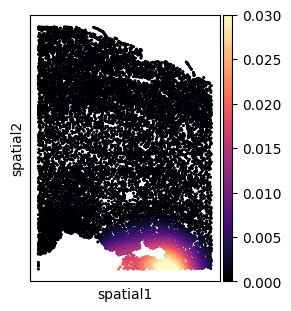

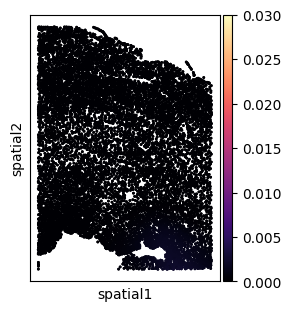

In [7]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,3),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
    vmin=0, vmax=0.03

)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.control.endo_nppa.pdf", bbox_inches='tight')

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,3),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
    vmin=0, vmax=0.03

)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.control.endo_myeloid.pdf", bbox_inches='tight')

### Day 2 sample

In [8]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

sample = "sample_2d_r2_s1"
adata = anndata_objects[sample]
cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)

adata_2d = adata

li.mt.lr_bivar(adata,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata_2d.obsm['local_scores']

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiomyocytes_Nppa+', 'Endocardial_cells', 'Endothelial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 9 self-interactions


... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lvl2' as categorical
... storing 'anno_cell_type_lvl3' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


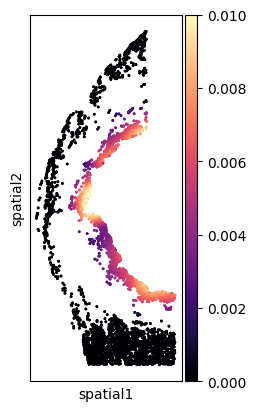

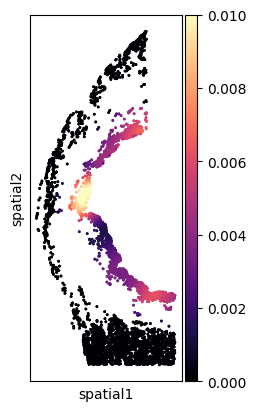

In [9]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    vmin = 0, vmax = 0.01,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.2d.endo_nppa.pdf", bbox_inches='tight')

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    vmin = 0, vmax = 0.01,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)
## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.2d.endo_myeloid.pdf", bbox_inches='tight')

### Day 4 sample

In [10]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

sample = "sample_4d_r1_s1"
adata = anndata_objects[sample]
cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)

li.mt.lr_bivar(adata,
            function_name='product', # Name of the function
            n_perms=None, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']

adata_d4 = adata

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiomyocytes_Nppa+', 'Endocardial_cells', 'Endothelial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 9 self-interactions


... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lvl2' as categorical
... storing 'anno_cell_type_lvl3' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


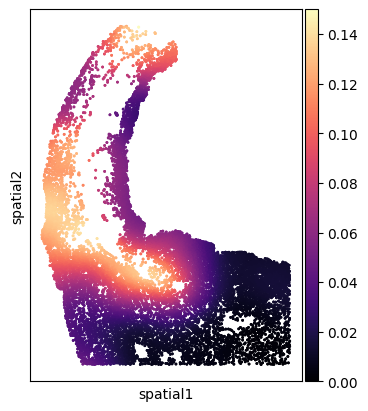

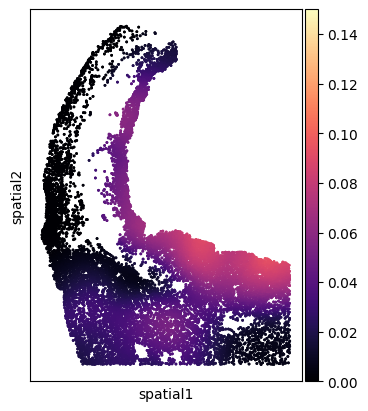

In [11]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiac_fibroblasts^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    vmin = 0, vmax = 0.15,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

#plt.show()

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.4d.cfib_myeloid.pdf", bbox_inches='tight', dpi=300)

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiomyocytes_Nppa+^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="magma",
    frameon = True,
    title = "",
    figsize = (4,4),
    vmin = 0, vmax = 0.15,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "upper left"},
)

#plt.show()

## Save this matplotlib plot as a pdf
plt.savefig("../../plots/molkart.liana_plus.4d.nppa_myeloid.pdf", bbox_inches='tight', dpi=300)

## Calculate distances between different cell types

### Endocardial cells - Myeloid cells

In [13]:
import seaborn as sns
palette = sns.color_palette('Set2')
# Select the first, third, and fourth elements
selected_colors = [palette[i] for i in [0, 2, 3]]
selected_colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

                sum_sq   df          F    PR(>F)
timepoint  1479.414003  2.0  31.939279  0.009501
Residual     69.479370  3.0        NaN       NaN
               2d        4d   control
2d       1.000000  1.000000  0.021827
4d       1.000000  1.000000  0.084153
control  0.021827  0.084153  1.000000


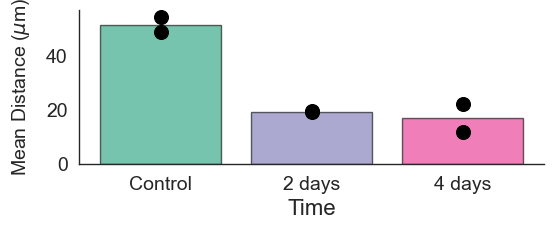

In [33]:
plot_size_factor = 2

##### control calculations
ndist_neighbours = 1
endo_distances_dict = {}
# Get the color palette
selected_colors = ["#1B9E77","#7570B3","#E7298A"]

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
        endo_cells = adata.obs['liana_cts'] == 'Endocardial_cells'
        endo_cells = adata.obsm['spatial'][endo_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid_cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        endo_distances = distance.cdist(endo_cells, myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with resolution 0.138 micrometer/pixel
        endo_distances = endo_distances * 0.138

        # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
        endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])
        
        # Calculate mean distance for this sample
        mean_distance = np.mean(endo_distances)

        # Store mean distance for this sample
        # Check if timepoint already exists and if so, append the mean value to the existing dict
        if timepoint in endo_distances_dict.keys():
            endo_distances_dict[timepoint].append(mean_distance)
        else:
            endo_distances_dict[timepoint] = [mean_distance]

import statsmodels.api as sm
from statsmodels.formula.api import ols
# Convert endo_distances_dict into a pandas data frame with column 'distance' and 'timepoint'
endo_distances_df = pd.DataFrame({'distance': np.concatenate(list(endo_distances_dict.values())),
                                'timepoint': np.concatenate([[key] * len(value) for key, value in endo_distances_dict.items()])})

# Use sm.stats.anova_lm to perform anova on endo_distances_df
aov_table = sm.stats.anova_lm(ols('distance ~ timepoint', data=endo_distances_df).fit(), typ=2)
print(aov_table)

import scikit_posthocs as sp
t_tests = sp.posthoc_ttest(endo_distances_df, val_col='distance', group_col='timepoint', p_adjust='bonferroni')
print(t_tests)
from statannotations.Annotator import Annotator
# Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(plot_size_factor*3,plot_size_factor))
# Calculate means for each timepoint
means = {k: np.mean(v) for k,v in endo_distances_dict.items()}

# Plot bars
x_pos = np.arange(len(means))
plt.bar(x_pos, list(means.values()), color=selected_colors, alpha=0.6, edgecolor='black', linewidth=1)

# Plot individual points
for i, (timepoint, values) in enumerate(endo_distances_dict.items()):
    plt.scatter([i]*len(values), values, color='black', s=100)

# Customize plot
plt.xticks(x_pos, ['Control', '2 days', '4 days'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Mean Distance ($\mu$m)', fontsize=14, labelpad=10)
plt.xlabel('Time', fontsize=16)
sns.despine()

plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')

### Cardiac Fibroblasts - Myeloid cells

               sum_sq   df          F    PR(>F)
timepoint  541.041766  2.0  35.531399  0.008152
Residual    22.840718  3.0        NaN       NaN
               2d        4d   control
2d       1.000000  0.203997  0.139005
4d       0.203997  1.000000  0.038214
control  0.139005  0.038214  1.000000


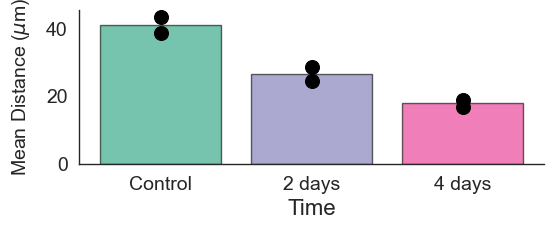

In [35]:
plot_size_factor = 2

##### control calculations
ndist_neighbours = 1
cfib_distances_dict = {}
# Get the color palette
selected_colors = ["#1B9E77","#7570B3","#E7298A"]

# Loop over anndata_objects and calculate the distances between Cardiac Fibroblasts and Myeloid cells for each sample and store the results in a list called cfib_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Cardiac Fibroblasts in adata.obs['liana_cts'] 
        cfib_cells = adata.obs['liana_cts'] == 'Cardiac_fibroblasts'
        cfib_cells = adata.obsm['spatial'][cfib_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid_cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        cfib_distances = distance.cdist(cfib_cells, myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with resolution 0.138 micrometer/pixel
        cfib_distances = cfib_distances * 0.138

        # For each row in cfib_distances, keep only the X smallest values and remove the other values from the array
        cfib_distances = np.array([np.sort(row)[:ndist_neighbours] for row in cfib_distances])
        
        # Calculate mean distance for this sample
        mean_distance = np.mean(cfib_distances)

        # Store mean distance for this sample
        # Check if timepoint already exists and if so, append the mean value to the existing dict
        if timepoint in cfib_distances_dict.keys():
            cfib_distances_dict[timepoint].append(mean_distance)
        else:
            cfib_distances_dict[timepoint] = [mean_distance]

import statsmodels.api as sm
from statsmodels.formula.api import ols
# Convert cfib_distances_dict into a pandas data frame with column 'distance' and 'timepoint'
cfib_distances_df = pd.DataFrame({'distance': np.concatenate(list(cfib_distances_dict.values())),
                                'timepoint': np.concatenate([[key] * len(value) for key, value in cfib_distances_dict.items()])})

# Use sm.stats.anova_lm to perform anova on cfib_distances_df
aov_table = sm.stats.anova_lm(ols('distance ~ timepoint', data=cfib_distances_df).fit(), typ=2)
print(aov_table)

import scikit_posthocs as sp
t_tests = sp.posthoc_ttest(cfib_distances_df, val_col='distance', group_col='timepoint', p_adjust='bonferroni')
print(t_tests)
from statannotations.Annotator import Annotator
# Set the order that the keys in cfib_distances_dict will be plotted to control, 4h, 2d, 4d
cfib_distances_dict = {key: cfib_distances_dict[key] for key in ['control', '2d', '4d']}
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(plot_size_factor*3,plot_size_factor))
# Calculate means for each timepoint
means = {k: np.mean(v) for k,v in cfib_distances_dict.items()}

# Plot bars
x_pos = np.arange(len(means))
plt.bar(x_pos, list(means.values()), color=selected_colors, alpha=0.6, edgecolor='black', linewidth=1)

# Plot individual points
for i, (timepoint, values) in enumerate(cfib_distances_dict.items()):
    plt.scatter([i]*len(values), values, color='black', s=100)

# Customize plot
plt.xticks(x_pos, ['Control', '2 days', '4 days'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Mean Distance ($\mu$m)', fontsize=14, labelpad=10)
plt.xlabel('Time', fontsize=16)
sns.despine()

plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.cfib_myeloid.pdf", bbox_inches='tight')

### Endocardial cells to all other cell types

In [6]:
##### control calculations
ndist_neighbours = 3
distances_dict = {}

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Calculate the distance between endo_cells and all other cell types in adata.obs['liana_cts'] 
        for ct in adata.obs['liana_cts'].unique():
            # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
            endo_cells = adata.obs['liana_cts'] == 'Endocardial cells'
            endo_cells = adata.obsm['spatial'][endo_cells]

            other_ct = adata.obs['liana_cts'] == ct
            other_ct = adata.obsm['spatial'][other_ct]

            from scipy.spatial import distance
            endo_distances = distance.cdist(endo_cells, other_ct, 'euclidean')
            # Transform the distances from pixel into micrometer by multiplying with 0.138
            endo_distances = endo_distances * 0.138

            # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
            endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])

            # Flatten the array
            #endo_distances = endo_distances.flatten()
            if ct in distances_dict.keys():
                if timepoint in distances_dict[ct].keys():
                    distances_dict[ct][timepoint] = np.append(distances_dict[ct][timepoint], endo_distances)
                else:
                    distances_dict[ct][timepoint] = endo_distances
            else:
                distances_dict[ct] = {}
                distances_dict[ct][timepoint] = endo_distances
        distances_dict.keys()

# for ct in distances_dict.keys():
#     # Set the order for the keys in distances_dict[ct].keys() to control, 2d, 4d
#     distances_dict[ct] = {key: distances_dict[ct][key] for key in ['control', '2d', '4d']}

#     sns.set_style('white')
#     sns.set_context("paper", font_scale = 2)
#     fig, ax = plt.subplots(figsize=(8,6))#
#     sns.violinplot(data = list(distances_dict[ct].values()), palette=selected_colors, ax=ax, alpha = 1)
    

#     # Plot data points on top of violin plots. Each data point should be a measurement from one cell
#     #sns.swarmplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5)

#     # Rename the x axis labels to control, 2d, 4d
#     plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
#     plt.title(ct)
#     # Remove the black border of the plottng area
#     sns.despine()
#     # Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
#     plt.ylabel('Distance ($\mu$m)')

#plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Myeloid cells'),
  Text(1, 0, 'Cardiac fibroblasts'),
  Text(2, 0, 'Pericytes'),
  Text(3, 0, 'Endothelial cells'),
  Text(4, 0, 'Cardiomyocytes'),
  Text(5, 0, 'Smooth muscle cells'),
  Text(6, 0, 'Cardiomyocytes Nppa+'),
  Text(7, 0, 'Endocardial cells'),
  Text(8, 0, 'Lymphoid cells')])

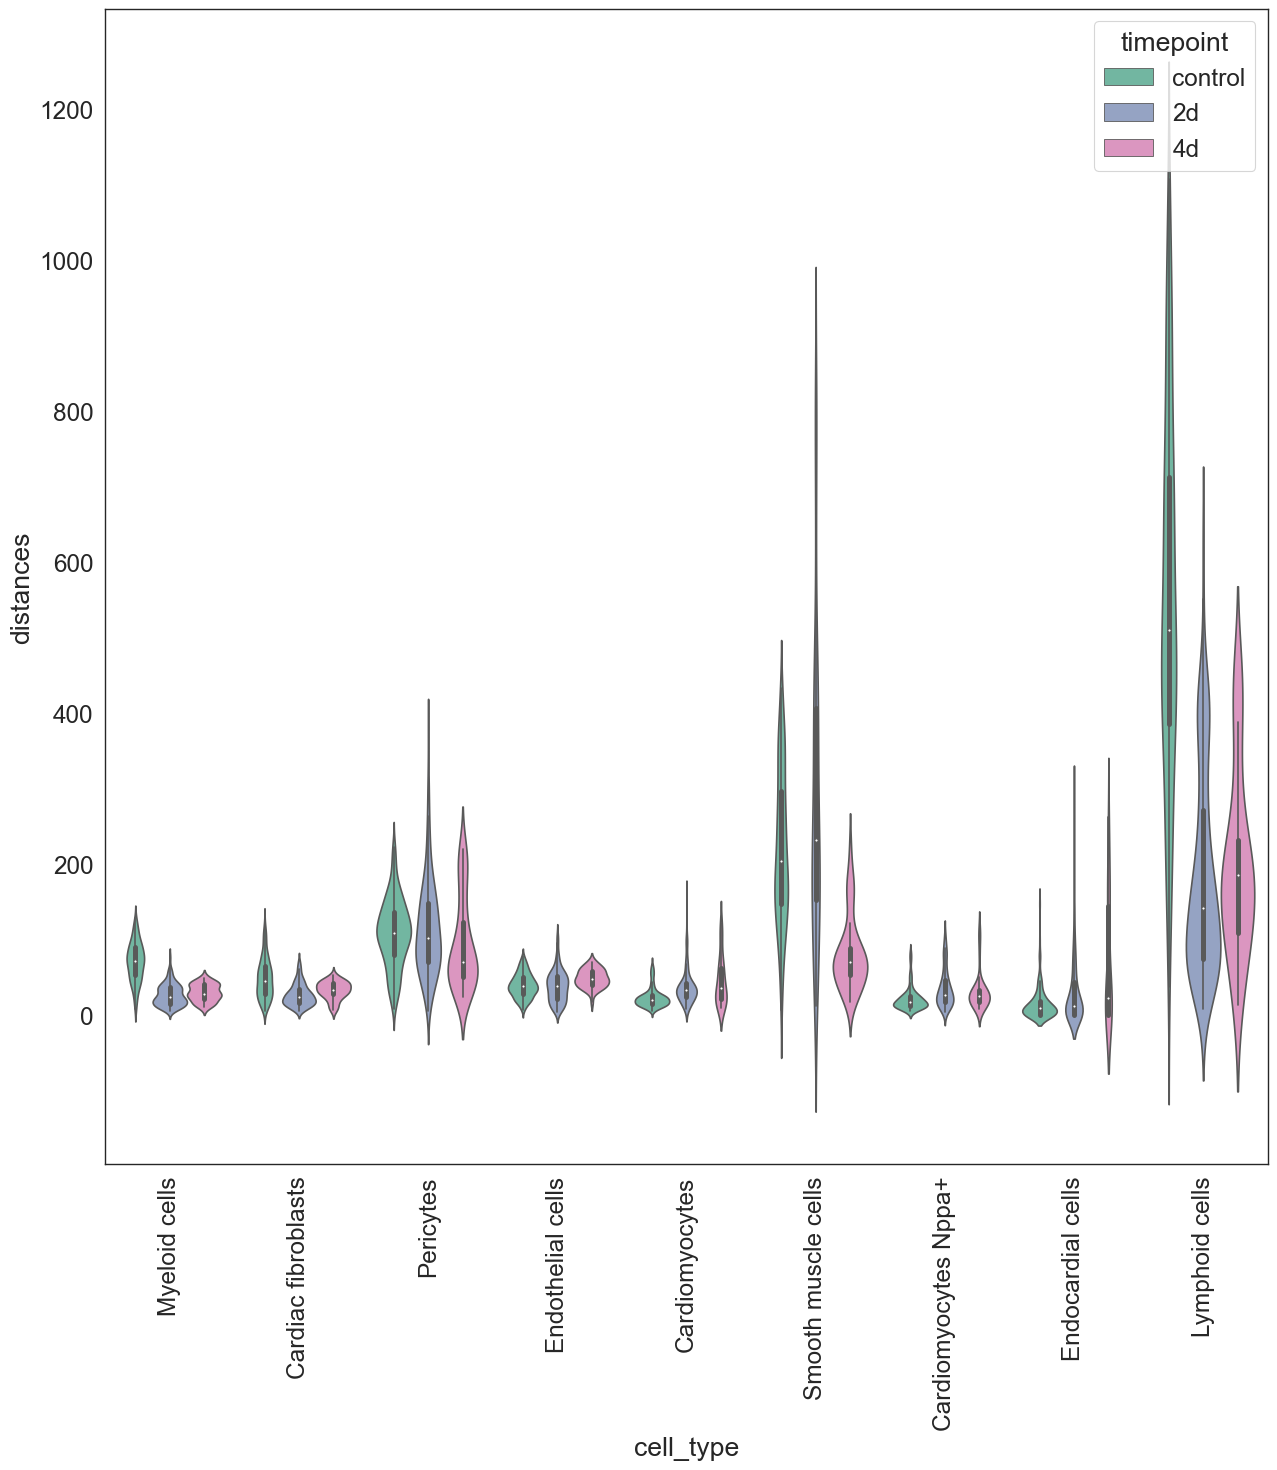

In [10]:
# Convert the contents from distances_dict into a pandas dataframe. Put the keys in distances_df into one column, the keys for each of the subdictionaries into another column and the values into a third column
distances_df = pd.DataFrame([(k, k2, v2) for k, v in distances_dict.items() for k2, v2 in v.items()], columns=['cell_type', 'timepoint', 'distances'])
# Modify distances_df so that each row contains the cell type, timepoint and distance to the closest myeloid cell for one cell
distances_df = distances_df.explode('distances')
# Subset for only timepoint d2 
# distances_df = distances_df[distances_df['timepoint'] == '2d']
# Keep only cell_types that can recruit myeloid cells : EndMA+, Endothelial_cells, 

# Set the order of colors in distances_df to be control, 2d, 4d
distances_df['timepoint'] = pd.Categorical(distances_df['timepoint'], categories=['control', '2d', '4d'])

# Convert the distances column from object to float
distances_df['distances'] = distances_df['distances'].astype(float)
# Plot the violin plot
sns.violinplot(data=distances_df, x="cell_type", y="distances", hue="timepoint", palette=selected_colors)
# Make plot bigger so all x axis labels are visible
plt.gcf().set_size_inches(15, 15)
# rotate x axis labels by 45 degrees
plt.xticks(rotation=90)

# Unused analysis

## Mesmer segmentation based cell-typing

In [24]:
from numpy.random import default_rng
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
import warnings
warnings.filterwarnings('ignore')
## Read in counts and coordinates
import pandas as pd

# Read in spatial data
metadata = pd.read_csv('../../output/molkart/mesmer_seg/harmony_object.metadata_anndata.tsv', index_col=False, sep= "\t")
centroids_groups = {name: group[['X_centroid', 'Y_centroid']].to_numpy() for name, group in metadata.groupby('sample_ID')}
# Please mirror the centroid_groups by the y-axis to match the coordinates of the image
for key, value in centroids_groups.items():
    value[:,1] = 1000 - value[:,1]

counts = pd.read_csv('../../output/molkart/mesmer_seg/harmony_object.counts_anndata.tsv', index_col=False, sep= "\t")
counts_groups = {name: csr_matrix(counts.loc[group.index].to_numpy()) for name, group in metadata.groupby('sample_ID')}

cell_types_groups = {name: group[['seurat_clusters','anno_cell_type_lvl2','liana_cts']] for name, group in metadata.groupby('sample_ID')}
## Generate an anndata object for each sample
anndata_objects = {name: ad.AnnData(counts_groups[name], 
                                    obsm={"spatial": centroids_groups[name]}) for name in metadata['sample_ID'].unique()}
## Set gene names
for name in anndata_objects.keys():
    anndata_objects[name].var_names = counts.columns
    metadata_subset = metadata[metadata['sample_ID'] == name]
    # Now use the row index from metadata_subset to subset the counts
    anndata_objects[name].layers['counts'] = counts.loc[metadata_subset.index].to_numpy()
    sc.pp.normalize_total(anndata_objects[name], target_sum=1e4)
    #sc.pp.log1p(adata)

## Set metadata
for name in anndata_objects.keys():
    anndata_objects[name].obs = cell_types_groups[name]
    anndata_objects[name].obs.index = anndata_objects[name].obs.index.astype(str)

scanpy==1.9.4 anndata==0.10.4 umap==0.5.3 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
squidpy==1.3.1


### Control

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:29<00:00,  2.92s/it]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


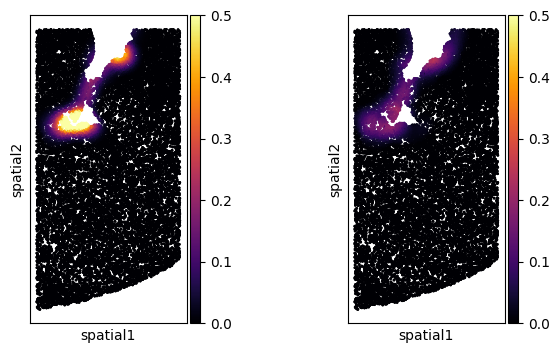

In [5]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_control_r2_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+","Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.5
)

plt.show()


## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

### 2 day sample

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:04<00:00,  2.24it/s]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


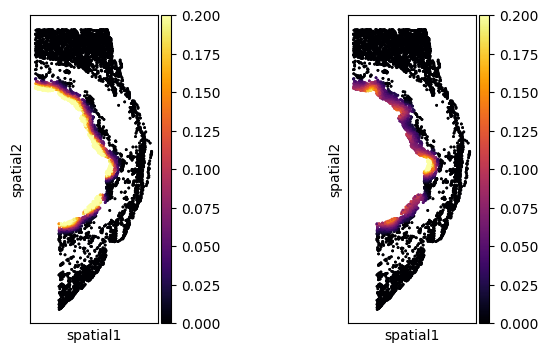

In [7]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_2d_r2_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+","Endocardial_cells^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.2
)

plt.show()


## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

### 4 day sample

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiac_fibroblasts_Il6+', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Lymphoid_cells', 'Myeloid_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 13 self-interactions
100%|██████████| 10/10 [00:36<00:00,  3.60s/it]
... storing 'anno_cell_type_lvl2' as categorical
... storing 'liana_cts' as categorical
... storing 'ligand' as categorical
... storing 'receptor' as categorical


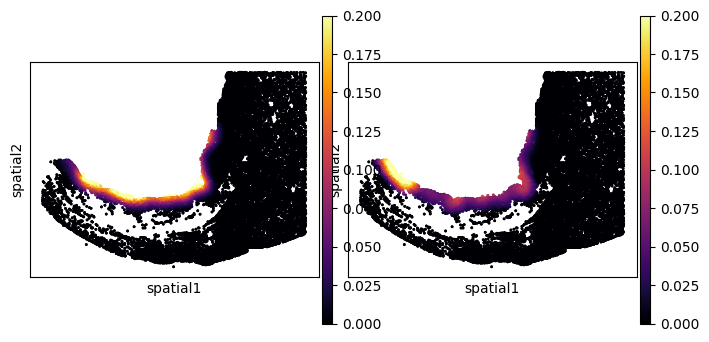

In [8]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

chosen_bandwith = 500
chosen_cutoff = 0.1

sample = "sample_4d_r1_s1"
adata = anndata_objects[sample]
# Make the x axis the y axis and vice versa
adata.obsm['spatial'][:,[0,1]] = adata.obsm['spatial'][:,[1,0]]
adata.obsm['spatial'][:,1] = 1000 - adata.obsm['spatial'][:,1]

cell_type_names = adata.obs['liana_cts'].unique()

onehot_ct = pd.get_dummies(adata.obs['liana_cts']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth= chosen_bandwith, cutoff= chosen_cutoff, kernel='gaussian', set_diag=False, standardize=True)
# sq.gr.spatial_neighbors(
#     adata,
#     n_neighs=150,
#     coord_type="generic",
#     delaunay=True,
# )
li.pl.connectivity(adata, idx=500, size=1)

adata_control = adata
li.mt.lr_bivar(adata,
            function_name='norm_product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.001, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']

## Save this matplotlib plot as a pdf
#plt.savefig("../../plots/molkart.liana_plus.control.pdf", bbox_inches='tight')

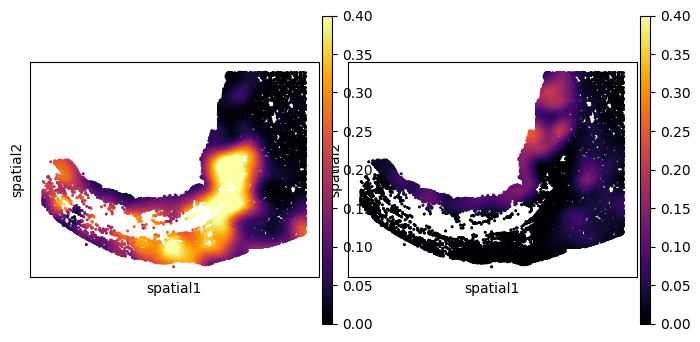

In [12]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiac_fibroblasts^Myeloid_cells","Cardiomyocytes_Nppa+^Myeloid_cells",
    ],
    shape=None,
    size=4,
    img=False,
    layer=None,
    cmap="inferno",
    frameon = True,
    title = "",
    figsize = (4,4),
    wspace = 0,
    # scalebar_dx=0.138,
    # scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    vmin=0, vmax=0.4
)

plt.show()

### Distances

Text(0, 0.5, 'Distance ($\\mu$m)')

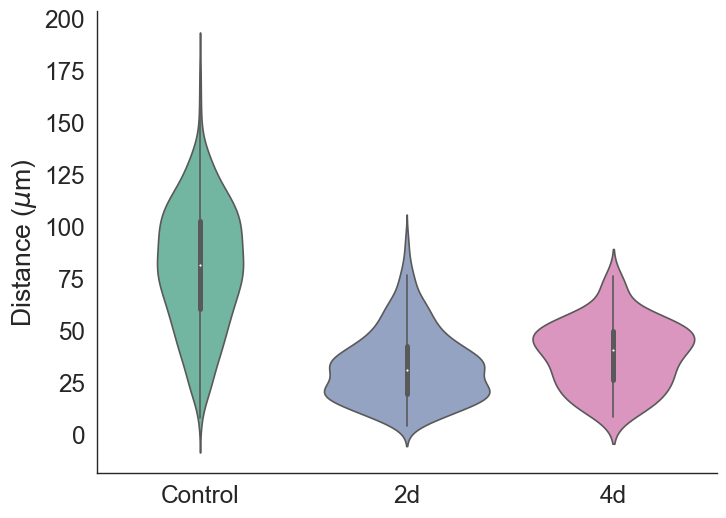

In [51]:
import seaborn as sns

##### control calculations
ndist_neighbours = 3
endo_distances_dict = {}
# Get the color palette
palette = sns.color_palette('Set2')
# Select the first, third, and fourth elements
selected_colors = [palette[i] for i in [0, 2, 3]]

# Loop over anndata_objects and calculate the distances between Endocardial cells and Myeloid cells for each sample and store the results in a list called endo_distances
for sample in anndata_objects.keys():
    # Get the timepoint from the sample name
    timepoint = sample.split('_')[1]

    # If timepint is 4h skip
    if timepoint == '4h':
        continue
    else:
        adata = anndata_objects[sample]
        # Get the positions in spatial for all cells annotated as Endocardial cells in adata.obs['liana_cts'] 
        endo_cells = adata.obs['liana_cts'] == 'Endocardial_cells'
        endo_cells = adata.obsm['spatial'][endo_cells]

        myeloid_cells = adata.obs['liana_cts'] == 'Myeloid_cells'
        myeloid_cells = adata.obsm['spatial'][myeloid_cells]

        from scipy.spatial import distance
        endo_distances = distance.cdist(endo_cells, myeloid_cells, 'euclidean')
        # Transform the distances from pixel into micrometer by multiplying with 0.138
        endo_distances = endo_distances * 0.138

        # For each row in endo_distances, keep only the 10 smallest values and remove the other values from the array
        endo_distances = np.array([np.sort(row)[:ndist_neighbours] for row in endo_distances])
        # Flatten the array
        endo_distances = endo_distances.flatten()

        # Check if timepoint already exists and if so, append the values to the existing dict
        if timepoint in endo_distances_dict.keys():
            endo_distances_dict[timepoint] = np.append(endo_distances_dict[timepoint], endo_distances)
        else:
            endo_distances_dict[timepoint] = endo_distances

# Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(8,6))
# Take the first, third and fourth color from the color palette 'Set2' in seaborn

# Plot the violin plots
sns.violinplot(data = list(endo_distances_dict.values()), palette=selected_colors, ax=ax, alpha = 1)

# Plot data points on top of violin plots. Each data point should be a measurement from one cell
#sns.swarmplot(data = list(endo_distances_dict.values()), color="black", alpha=0.5)

# Rename the x axis labels to control, 2d, 4d
plt.xticks([0, 1, 2], ['Control', '2d', '4d'])
#plt.title('Endocardial cells')
# Remove the black border of the plottng area
sns.despine()
# Add ylab that says distance to closest myeloid cell (micrometer) with the scientific symbol for micrometer
plt.ylabel('Distance ($\mu$m)')

#plt.savefig("../../plots/molkart.liana_plus.distance_boxplot.endocard_myeloid.pdf", bbox_inches='tight')